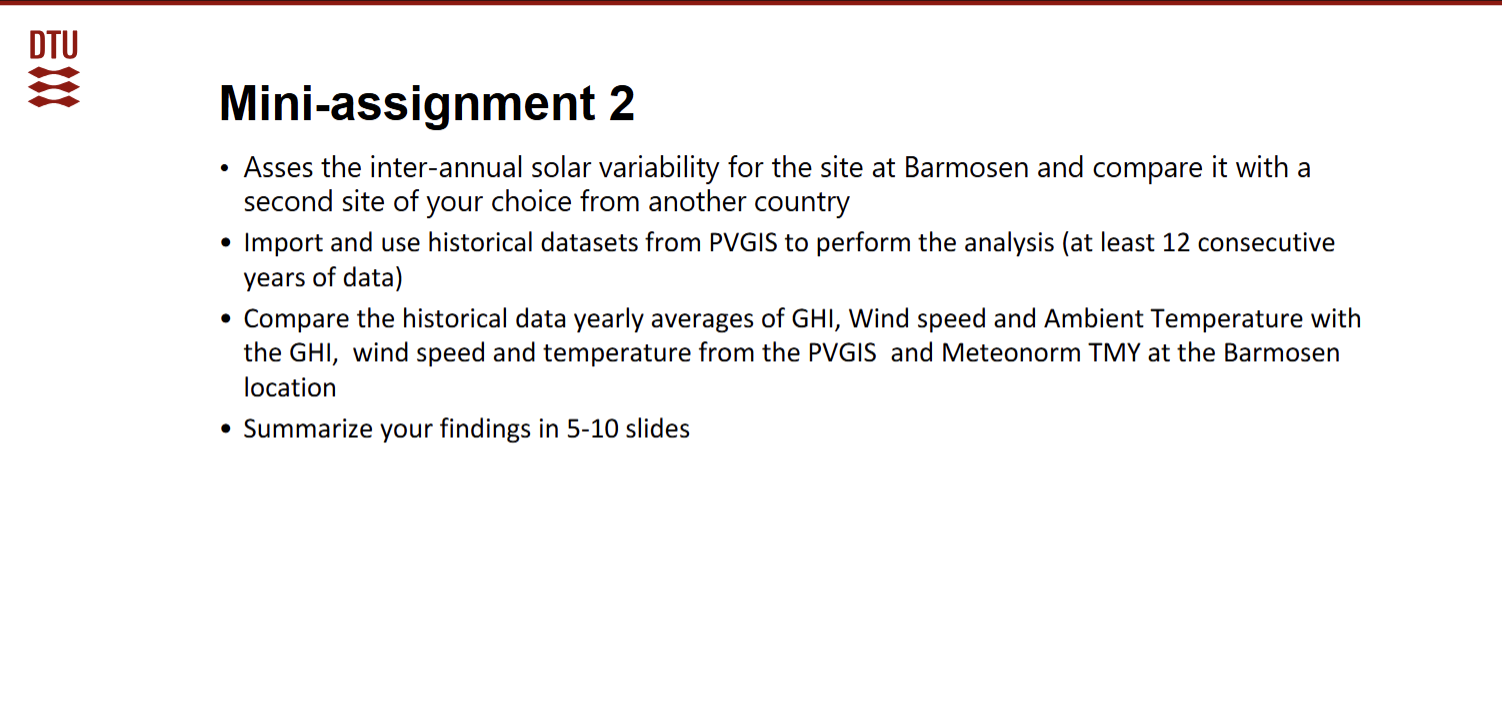

**First Location** 
Balmosen - France
Latitude : 43.7781
Longitude : 4.6395

**Second Location**
El Aromo - Ecuador
Latitude : -1.0710
Longitude : -80.7912

In [26]:
import re, os,pandas as pd, numpy as np, matplotlib.pyplot as plt
from zoneinfo import ZoneInfo

In [27]:
barm_PVGis_path= "Timeseries_Barmosen_2011_2023.csv"
aromo_PVGis_path = "Timeseries_El_Aromo_2011_2023.csv"

**PVGIS CSV READER** 

In [28]:
def read_pvgis_timeseries(path: str) -> pd.DataFrame:
    # find header and separator
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        lines = f.readlines()
    sep = ';' if ';' in lines[0] or any(';' in ln for ln in lines[:50]) else ','
    header_idx = None
    for i, ln in enumerate(lines[:200]):
        parts = [p.strip() for p in ln.strip().split(sep)]
        if any(p.lower() == 'time' for p in parts):
            header_idx = i; break
    if header_idx is None:
        for i, ln in enumerate(lines[:200]):
            if re.match(r'^\s*time\s*[,;]', ln, flags=re.I):
                header_idx = i; break
    if header_idx is None:
        raise ValueError("Could not detect header row with 'time'")
    df = pd.read_csv(path, sep=sep, skiprows=header_idx, engine='python')
    df.columns = [re.sub(r'\s*\(.*?\)', '', c).strip() for c in df.columns]
    tcol = 'time' if 'time' in df.columns else [c for c in df.columns if c.lower()=='time'][0]
    # try iso parse, else fallback to PVGIS custom format YYYYMMDD:HHMM
    t = pd.to_datetime(df[tcol], utc=True, errors='coerce')
    if t.isna().mean() > 0.5:
        t = pd.to_datetime(df[tcol], format='%Y%m%d:%H%M', utc=True, errors='coerce')
    df[tcol] = t
    df = df.dropna(subset=[tcol]).set_index(tcol).sort_index()
    return df



**DEFINING METRICS** 

In [29]:
def yearly_metrics_numeric(df, cols):
    d = df.copy()
    for c in [cols["ghi"], cols["temp"], cols["wind"]]:
        if c:
            d[c] = pd.to_numeric(d[c], errors='coerce')
    d["GHI_kWhm2"] = d[cols["ghi"]] / 1000.0
    annual = pd.DataFrame({"GHI_kWhm2_yr": d["GHI_kWhm2"].resample("Y").sum()})
    if cols["temp"] in d.columns:
        annual["Temp_C_mean"] = d[cols["temp"]].resample("Y").mean()
    if cols["wind"] in d.columns:
        annual["Wind_ms_mean"] = d[cols["wind"]].resample("Y").mean()
    annual.index = annual.index.year
    return annual

def variability(annual):
    out = {}
    for col in annual.columns:
        s = annual[col].dropna()
        mu = s.mean(); sd = s.std(ddof=1)
        out[col] = {"mean": mu, "std": sd, "cov%": (sd/mu*100 if mu else np.nan)}
    return pd.DataFrame(out).round(2)

def monthly_means(df):
    dfm = df.copy()
    dfm["month"] = dfm.index.month
    return dfm.groupby("month").mean(numeric_only=True)


**LOAD INFORMATION**

From PVGis cvs files in time series

In [30]:
# PVGIS data
barm_PVGis = read_pvgis_timeseries(barm_PVGis_path)
aromo_PVGis  = read_pvgis_timeseries(aromo_PVGis_path)

barm_PVGis_cols = {'ghi':'G','temp':'T2m','wind':'WS10m'}
aromo_PVGis_cols = {'ghi':'G','temp':'T2m','wind':'WS10m'}

C:\Users\Dmora\AppData\Local\Temp\ipykernel_62828\4102915625.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  t = pd.to_datetime(df[tcol], utc=True, errors='coerce')
C:\Users\Dmora\AppData\Local\Temp\ipykernel_62828\4102915625.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  t = pd.to_datetime(df[tcol], utc=True, errors='coerce')


Annual metrics 

C:\Users\Dmora\AppData\Local\Temp\ipykernel_62828\212014053.py:7: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual = pd.DataFrame({"GHI_kWhm2_yr": d["GHI_kWhm2"].resample("Y").sum()})
C:\Users\Dmora\AppData\Local\Temp\ipykernel_62828\212014053.py:9: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual["Temp_C_mean"] = d[cols["temp"]].resample("Y").mean()
C:\Users\Dmora\AppData\Local\Temp\ipykernel_62828\212014053.py:11: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual["Wind_ms_mean"] = d[cols["wind"]].resample("Y").mean()
C:\Users\Dmora\AppData\Local\Temp\ipykernel_62828\212014053.py:7: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual = pd.DataFrame({"GHI_kWhm2_yr": d["GHI_kWhm2"].resample("Y").sum()})
C:\Users\Dmora\AppData\Local\Temp\ipykernel_62828\212014

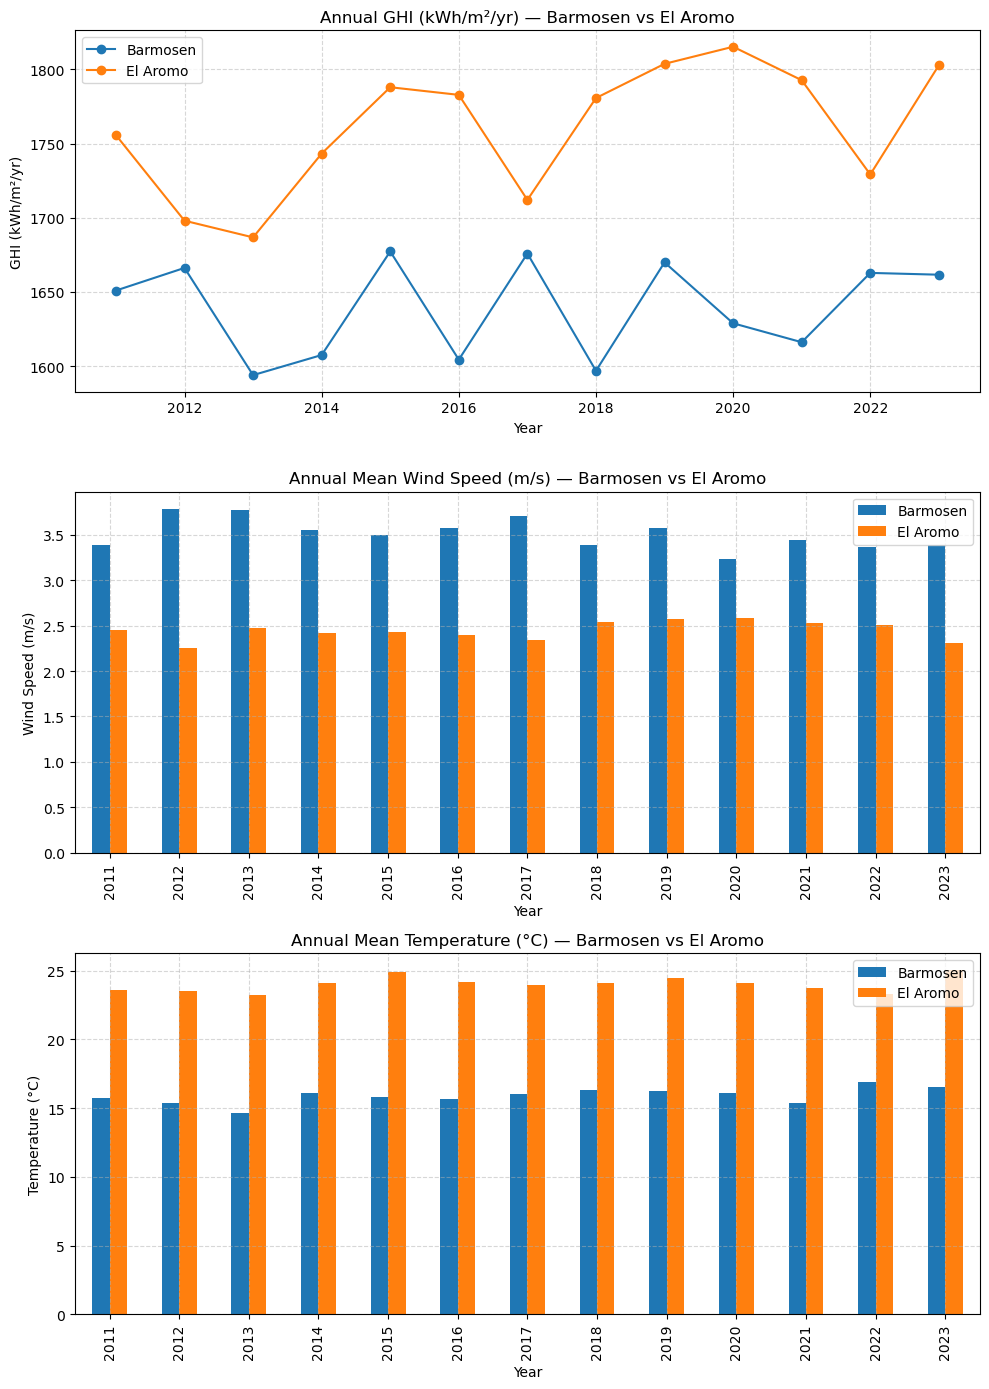

In [31]:
barm_PVGis_ann = yearly_metrics_numeric(barm_PVGis, barm_PVGis_cols)
aromo_PVGis_ann = yearly_metrics_numeric(aromo_PVGis, aromo_PVGis_cols)

fig, axes = plt.subplots(3, 1, figsize=(10, 14), sharex=False)

# 1) Annual GHI
axes[0].plot(barm_PVGis_ann.index, barm_PVGis_ann["GHI_kWhm2_yr"], marker="o", label="Barmosen")
axes[0].plot(aromo_PVGis_ann.index, aromo_PVGis_ann["GHI_kWhm2_yr"], marker="o", label="El Aromo")
axes[0].set_title("Annual GHI (kWh/m²/yr) — Barmosen vs El Aromo")
axes[0].set_xlabel("Year"); axes[0].set_ylabel("GHI (kWh/m²/yr)")
axes[0].legend(); axes[0].grid(True, linestyle="--", alpha=0.5)

# 2) Annual Wind speed
wind_bar = pd.DataFrame({
    "Barmosen": barm_PVGis_ann["Wind_ms_mean"],
    "El Aromo": aromo_PVGis_ann["Wind_ms_mean"]
})
wind_bar.plot(kind="bar", ax=axes[1])
axes[1].set_title("Annual Mean Wind Speed (m/s) — Barmosen vs El Aromo")
axes[1].set_xlabel("Year"); axes[1].set_ylabel("Wind Speed (m/s)")
axes[1].grid(True, linestyle="--", alpha=0.5)

# 3) Annual Temperature
temp_bar = pd.DataFrame({
    "Barmosen": barm_PVGis_ann["Temp_C_mean"],
    "El Aromo": aromo_PVGis_ann["Temp_C_mean"]
})
temp_bar.plot(kind="bar", ax=axes[2])
axes[2].set_title("Annual Mean Temperature (°C) — Barmosen vs El Aromo")
axes[2].set_xlabel("Year"); axes[2].set_ylabel("Temperature (°C)")
axes[2].grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

Statistics 

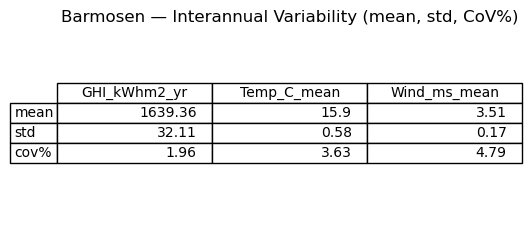

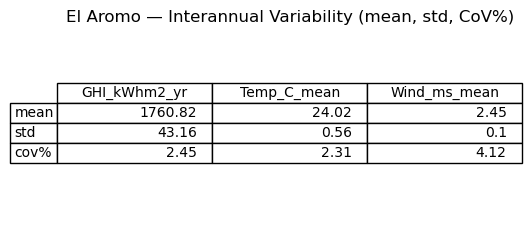

In [32]:
barm_PVGis_stats = variability(barm_PVGis_ann)
aromo_PVGis_stats = variability(aromo_PVGis_ann)

for name, stats in [("Barmosen", barm_PVGis_stats), ("El Aromo", aromo_PVGis_stats)]:
    fig, ax = plt.subplots(figsize=(6,2.4))
    ax.axis("off")
    tbl = ax.table(cellText=stats.values,
                   colLabels=stats.columns,
                   rowLabels=stats.index,
                   loc="center")
    tbl.scale(1,1.2)
    plt.title(f"{name} — Interannual Variability (mean, std, CoV%)")
    plt.show()

Montly metrics 

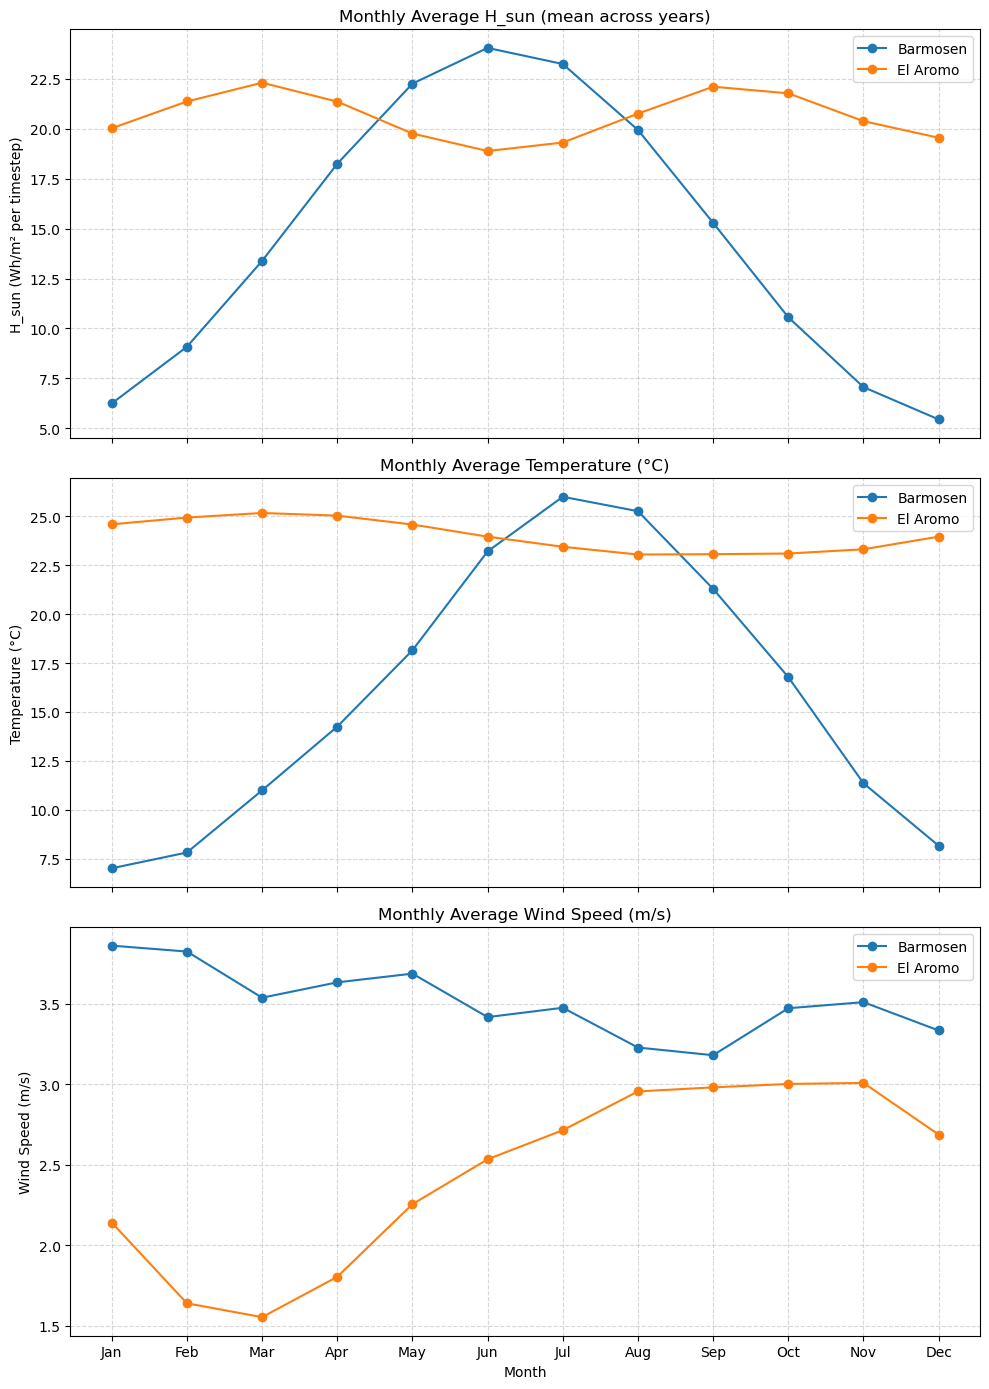

In [33]:
barm_monthly = monthly_means(barm_PVGis)
aro_monthly  = monthly_means(aromo_PVGis)

months = range(1,13)
month_labels = [pd.to_datetime(str(m), format="%m").strftime("%b") for m in months]

for dfm in (barm_monthly, aro_monthly):
    for col in ("H_sun", "T2m", "WS10m"):
        if col in dfm.columns:
            dfm[col] = pd.to_numeric(dfm[col], errors="coerce")

fig, axes = plt.subplots(3, 1, figsize=(10, 14), sharex=True)

# --- 1) Monthly GHI (mean per month across all years) ---
axes[0].plot(months, barm_monthly["H_sun"], marker="o", label="Barmosen")
axes[0].plot(months, aro_monthly["H_sun"],  marker="o", label="El Aromo")
axes[0].set_title("Monthly Average H_sun (mean across years)")
axes[0].set_ylabel("H_sun (Wh/m² per timestep)")
axes[0].legend()
axes[0].grid(True, linestyle="--", alpha=0.5)

# --- 2) Monthly Temperature ---
axes[1].plot(months, barm_monthly["T2m"], marker="o", label="Barmosen")
axes[1].plot(months, aro_monthly["T2m"],  marker="o", label="El Aromo")
axes[1].set_title("Monthly Average Temperature (°C)")
axes[1].set_ylabel("Temperature (°C)")
axes[1].legend()
axes[1].grid(True, linestyle="--", alpha=0.5)

# --- 3) Monthly Wind Speed ---
axes[2].plot(months, barm_monthly["WS10m"], marker="o", label="Barmosen")
axes[2].plot(months, aro_monthly["WS10m"],  marker="o", label="El Aromo")
axes[2].set_title("Monthly Average Wind Speed (m/s)")
axes[2].set_ylabel("Wind Speed (m/s)")
axes[2].set_xlabel("Month")
axes[2].legend()
axes[2].grid(True, linestyle="--", alpha=0.5)

# X-axis month labels
for ax in axes:
    ax.set_xticks(months)
    ax.set_xticklabels(month_labels)

plt.tight_layout()
plt.show()